In [1]:
import sys
sys.path.insert(0, "../../python")

import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from vsim import plot
from vsim import load
from vsim import analyze
import matplotlib.colors as colors
plt.style.use('notes')
from scipy.optimize import curve_fit
import scipy.constants as const
me = const.physical_constants['electron mass energy equivalent in MeV'][0]
c = const.physical_constants['speed of light in vacuum'][0]
e = const.physical_constants['elementary charge'][0]

pathPre = '/home/robert/CU-PWFA/emittance_preservation/simulations/PlasmaWidth/'

In [2]:
plasma_width = np.array([140, 175, 210, 245, 280])
gradient = np.zeros(len(plasma_width))

In [3]:
def alpha_colormap(cmap, cutoff, flip=True):
    N = cmap.N
    cmapt = cmap(np.arange(N))
    alpha = np.ones(N)
    if flip:
        temp = alpha[:int(cutoff*N)]
        M = len(temp)
        alpha[:int(cutoff*N)] = np.linspace(0, 1, M)
    else:
        alpha[int((1-cutoff)*N):] = 0.0
    cmapt[:, -1] = alpha
    cmapt = colors.ListedColormap(cmapt)
    return cmapt

def plot_sim():
    N = len(plasma_width)
    plt.figure(figsize=(18,8), dpi=300)
    gs = gridspec.GridSpec(4, N)
    
    for j in range(N):
        path = pathPre + '%0dum/' % (plasma_width[j])
        data = np.load(path + 'AcceleratingGradient.npy').item()
        gradient[j] = (data['energy'][19] - data['energy'][7])/(data['x'][19] - data['x'][7])
        density = np.load(path + 'DensitySlice.npy').item()

        # Load in plasma density
        ind = 19
        rhoXY = -np.transpose(density['rhoP'][ind]/e/1e6)+2 #+2 makes it greater than 0 for log scale
        x = density['xfield']
        y = density['yfield']
        
        #Load in the beam densities
        rhoBXY = -np.transpose(density['rhoB'][ind]/e/1e6)
        
        ax1 = plt.subplot(gs[0, j])
        plt.plot(data['x']*1e6, data['energy']/1e3)
        if j == 0:
            plt.ylabel('Energy (GeV)')
        plt.xlabel(r'z ($\mu m$)')
        plt.title('%0dum' % (plasma_width[j]))
        plt.twinx()
        plt.plot(data['x'][1:]*1e6, data['gradient']/1e3, 'm')
        if j == N-1:
            plt.ylabel('Gradient (GeV/m)')

        plt.subplot(gs[1, j])
        #for k in range(len(data['x'])):
        k = 6
        plt.plot(data['xfield']*1e6, data['field'][k, :]/1e9, label=('%0.2f' % (data['x'][k]*1e6)))
        if j == 0:
            plt.ylabel('Field (GeV/m)')
        plt.xlabel(r'z ($\mu m$)')

        plt.subplot(gs[2, j])
        plt.plot(data['x']*1e6, data['gamma_rms'], 'g')
        plt.xlabel(r'z ($\mu m$)')
        if j == 0:
            plt.ylabel('Energy spread (%)')
        
        ax = plt.subplot(gs[3, j])
        ax.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150],
           norm=colors.LogNorm(vmin=1e16, vmax=1e18), cmap='inferno')
        cmapW = alpha_colormap(plt.cm.get_cmap('rainbow'), 0.1, True)
        ax.imshow(rhoBXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150], cmap=cmapW)
        plt.xlabel(r'z ($\mu m$)')
        if j == 0:
            plt.ylabel(r'x ($\mu m$)')
        plt.tight_layout()
        
    plt.show()

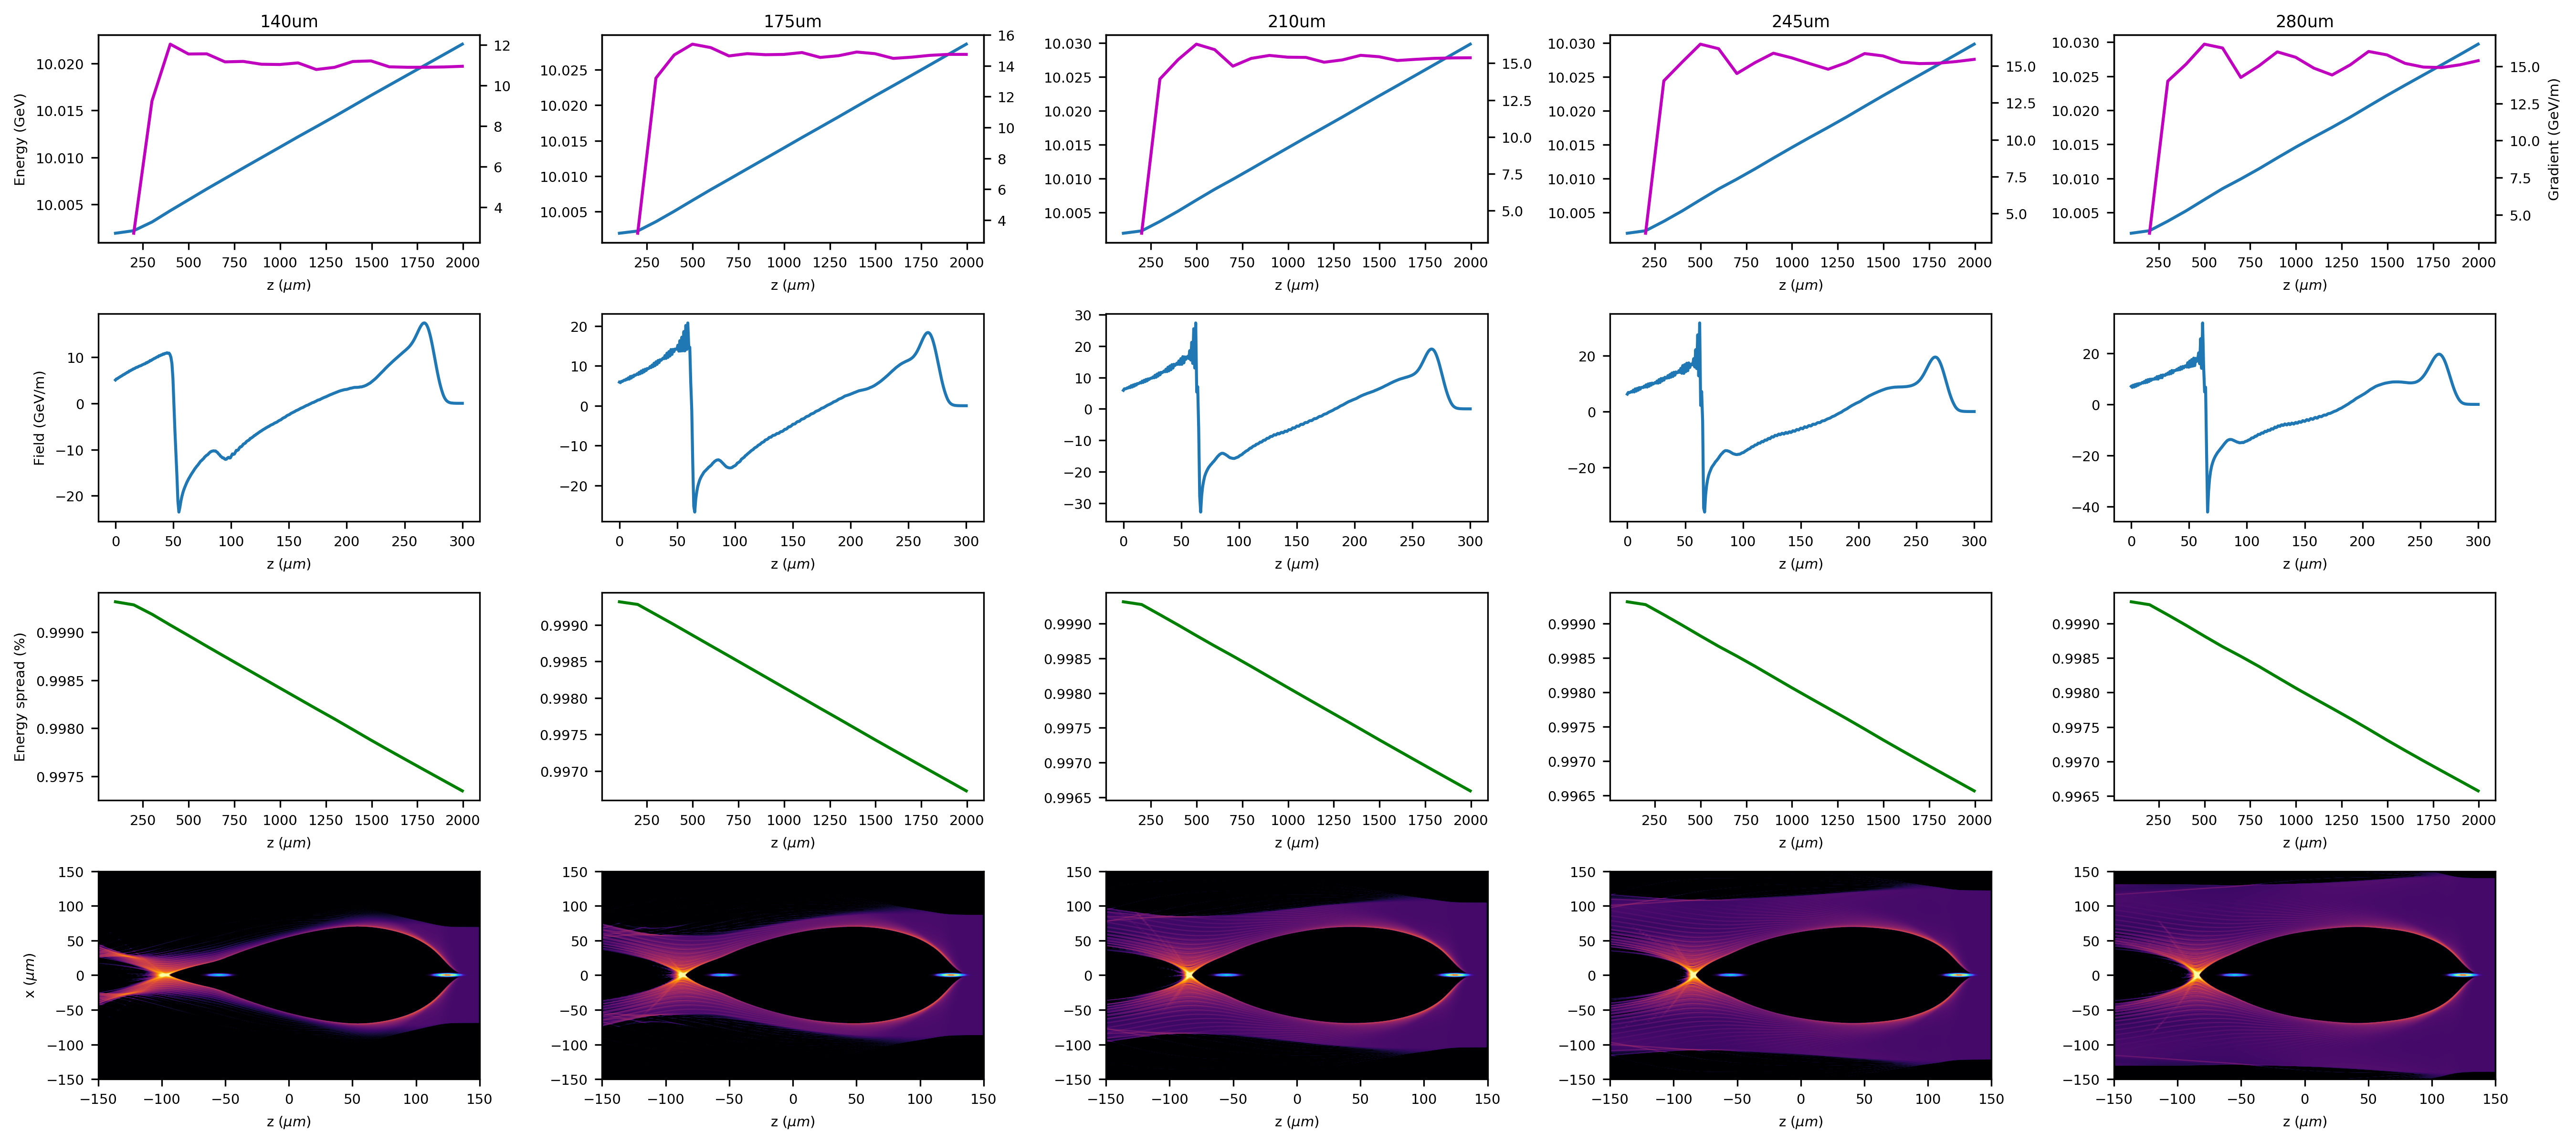

In [4]:
plot_sim()

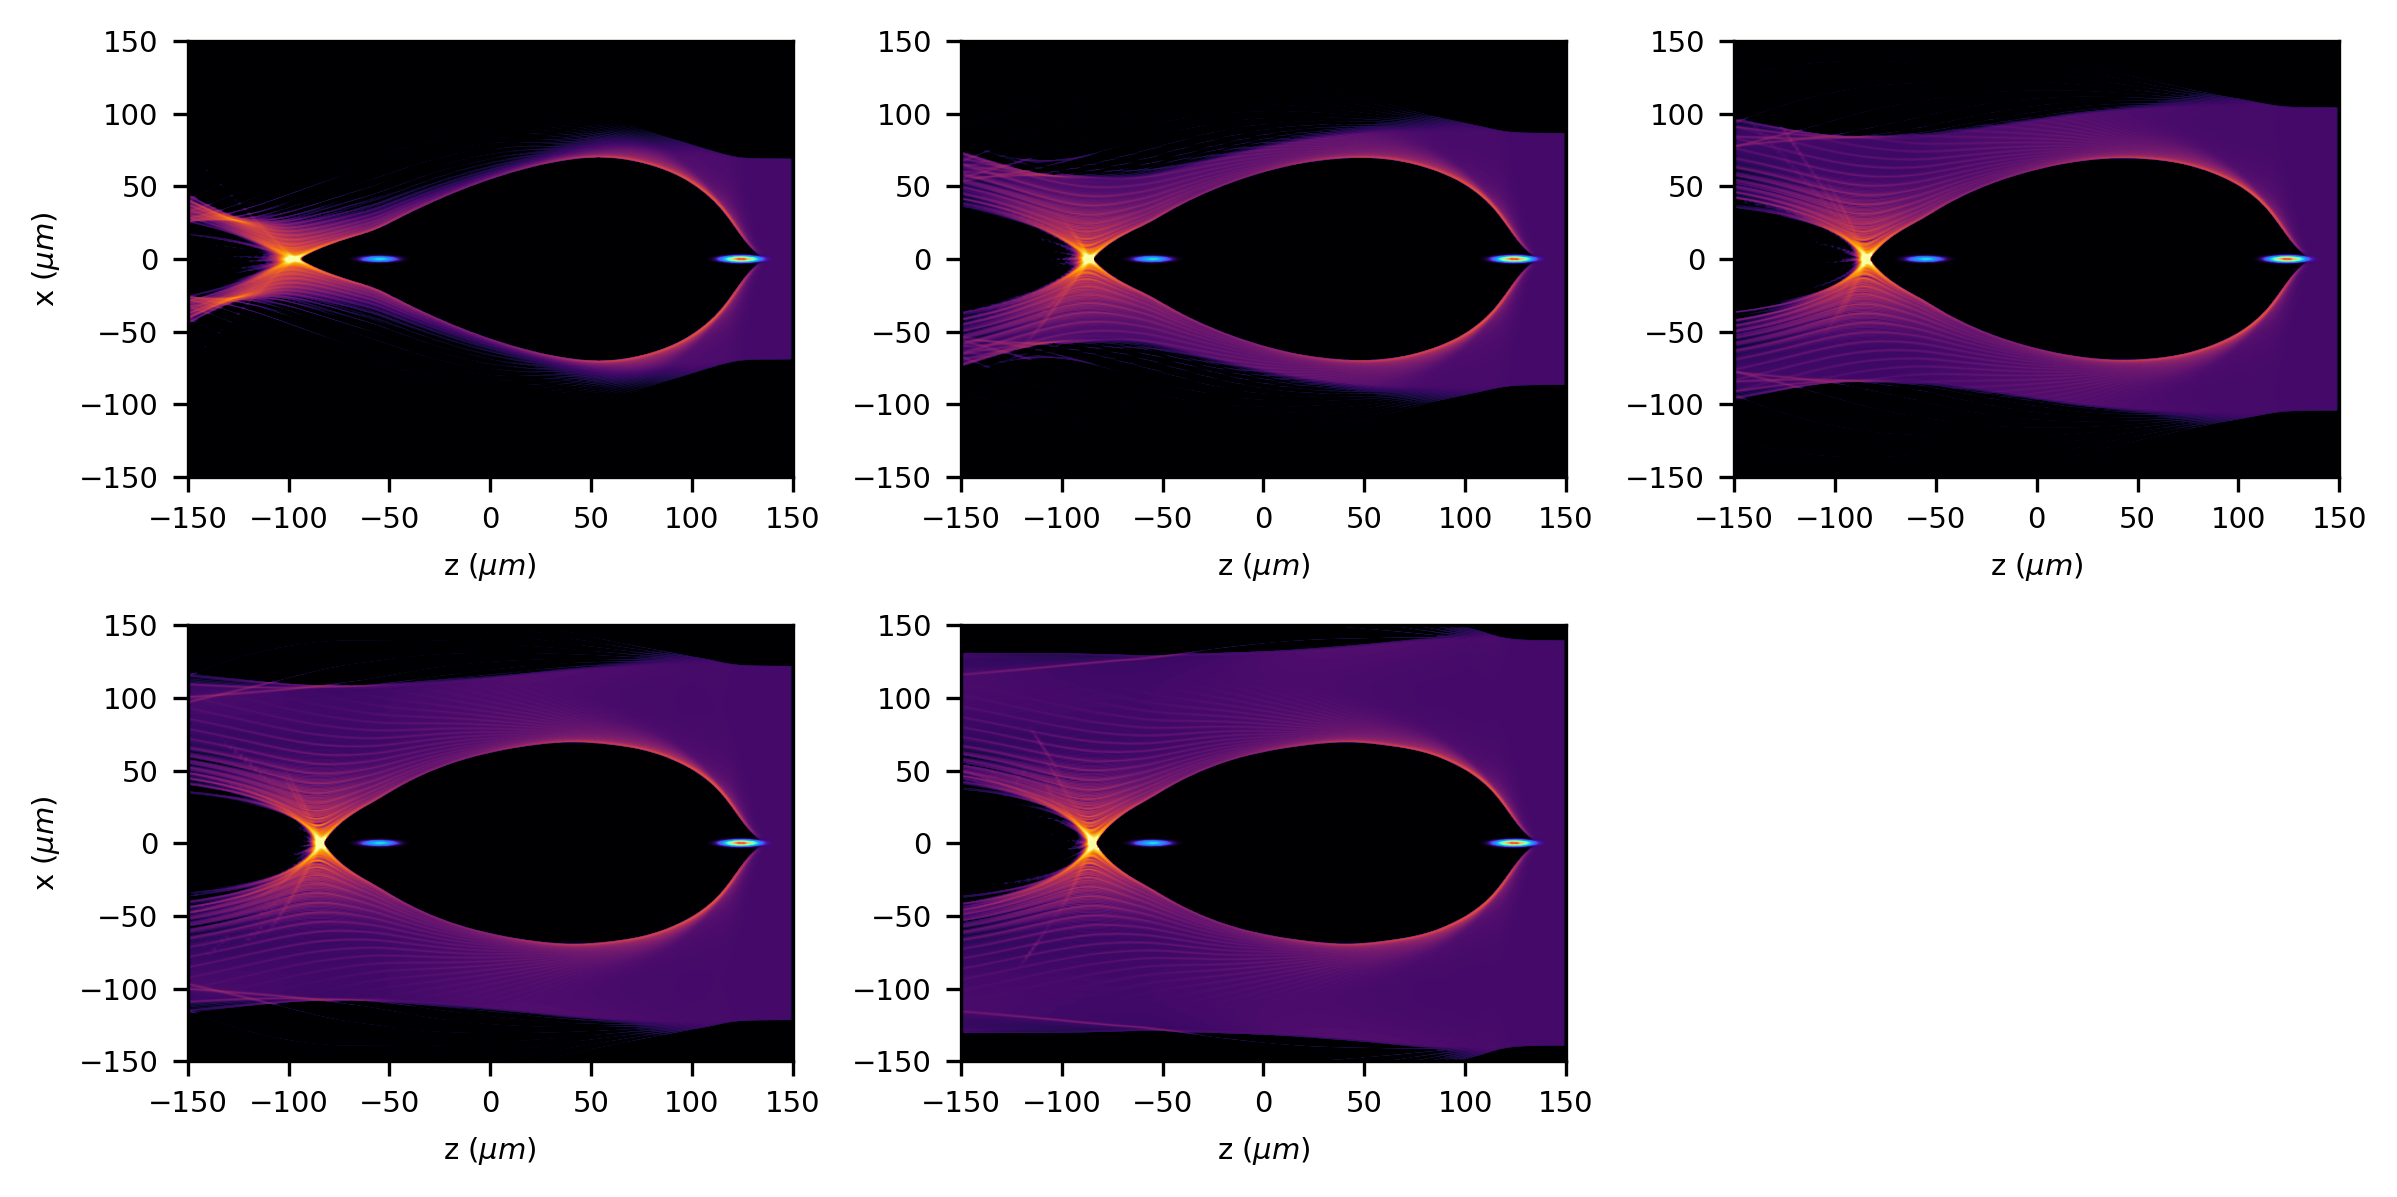

In [5]:
def plot_den():
    N = len(plasma_width)
    plt.figure(figsize=(8,4), dpi=300)
    gs = gridspec.GridSpec(2, 3)
    
    for j in range(N):
        path = pathPre + '%0dum/' % (plasma_width[j])
        data = np.load(path + 'AcceleratingGradient.npy').item()
        gradient[j] = (data['energy'][19] - data['energy'][7])/(data['x'][19] - data['x'][7])
        density = np.load(path + 'DensitySlice.npy').item()

        # Load in plasma density
        ind = 19
        rhoXY = -np.transpose(density['rhoP'][ind]/e/1e6)+2 #+2 makes it greater than 0 for log scale
        x = density['xfield']
        y = density['yfield']
        
        #Load in the beam densities
        rhoBXY = -np.transpose(density['rhoB'][ind]/e/1e6)
        
        col = j % 3
        row = int(j/3)
        ax = plt.subplot(gs[row, col])
        ax.imshow(rhoXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150],
           norm=colors.LogNorm(vmin=1e16, vmax=1e18), cmap='inferno')
        cmapW = alpha_colormap(plt.cm.get_cmap('rainbow'), 0.1, True)
        ax.imshow(rhoBXY, interpolation='gaussian', aspect='auto', extent=[-150, 150, -150, 150], cmap=cmapW)
        plt.xlabel(r'z ($\mu m$)')
        if col == 0:
            plt.ylabel(r'x ($\mu m$)')
        plt.tight_layout()
        
    plt.show()
plot_den()

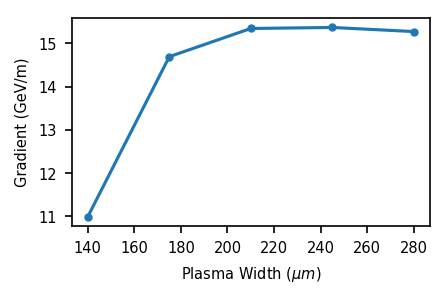

In [6]:
plt.figure(figsize=(3,2), dpi=150)
plt.plot(plasma_width, gradient/1e3, marker='o', markersize=3)
plt.ylabel('Gradient (GeV/m)')
plt.xlabel(r'Plasma Width ($\mu m$)')
plt.tight_layout()
plt.show()

In [7]:
# Look at the accelerating field in the vicinity of the beam to determine wake loading
# I want a better way to quantify the loading, I'll try energy spread after 10GeV of acceleration
spread = np.zeros(len(plasma_width))

def plot_energy_spread():
    N = len(plasma_width)
    plt.figure(figsize=(12,4), dpi=150)
    gs = gridspec.GridSpec(2, 3)
    
    
    for j in range(N):
        path = pathPre + '%0dum/' % (plasma_width[j])
        data = np.load(path + 'AcceleratingGradient.npy').item()
               
        plt.subplot(gs[int(j/3), j%3])
        k = 6
        plt.plot(data['xfield']*1e6, data['field'][k, :]/1e9, label=('%0.2f' % (data['x'][k]*1e6)))
        if j%3 == 0:
            plt.ylabel('Field (GeV/m)')
        plt.xlabel(r'z ($\mu m$)')
        plt.ylim(-50, 0)
        plt.twinx()
        
        center = 300-180-26
        centerInd = int(center*300/250)
        size = 5*5.2
        beamDensity = np.exp(-(data['xfield']*1e6-center)**2/(2*5.2**2))
        plt.plot(data['xfield']*1e6, beamDensity, 'm')
        if j%3 == 2:
            plt.ylabel('Beam density')
        plt.xlim(center-size, center+size)
        plt.title('%0dum' % (plasma_width[j]))
        
        # Calculate the standard deviation in energy after acceleration
        L = -10/data['field'][k, centerInd]*1e9
        finalE = -data['field'][k, :]/1e9 * L + 10.0
        Eavg = np.average(finalE, weights=beamDensity)
        Estd = np.sqrt(np.average((finalE-Eavg)**2, weights=beamDensity))
        Erel = Estd/Eavg*100
        spread[j] = Erel
        #plt.text(center+size-2*180, 0.2, r'$\sigma_E=%0.1f$' % Erel)
        
    plt.tight_layout()
    plt.show()

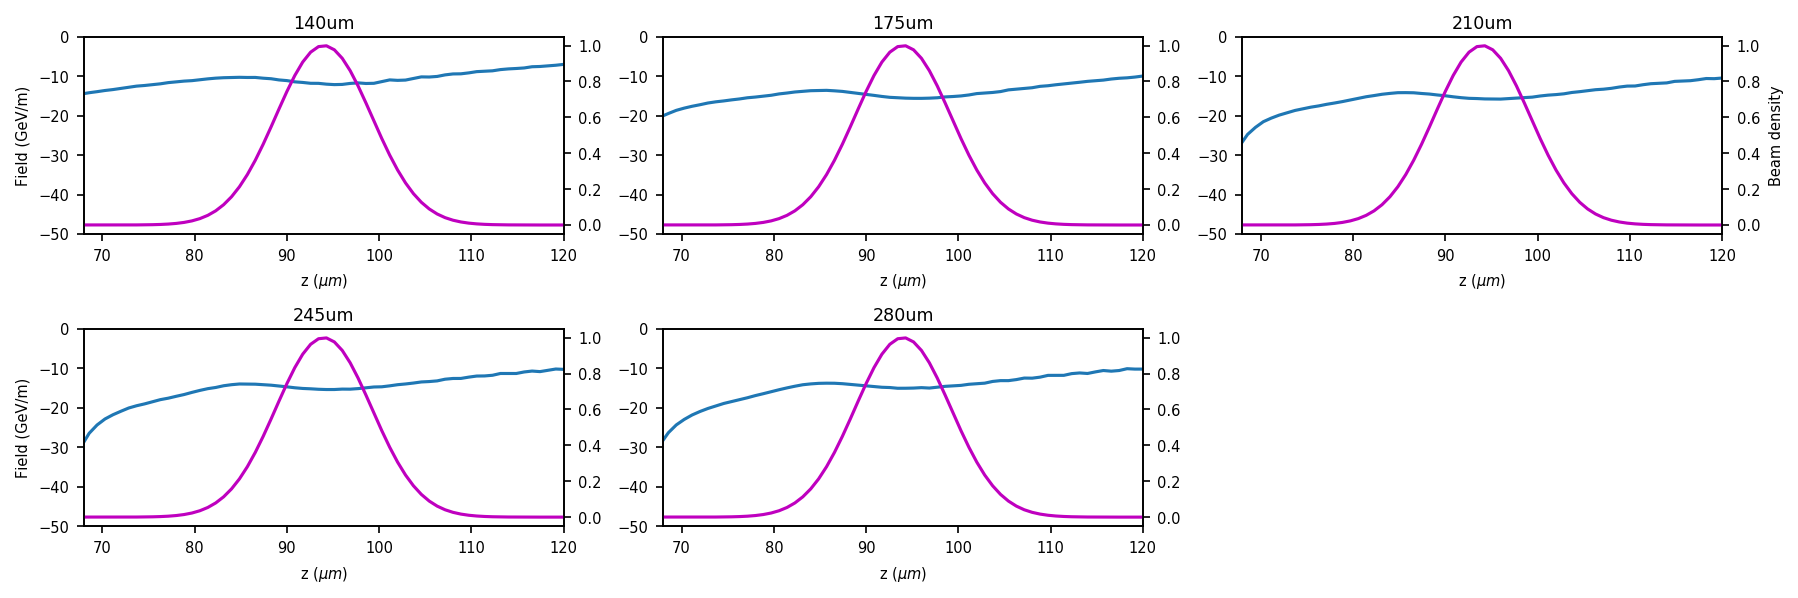

In [8]:
plot_energy_spread()

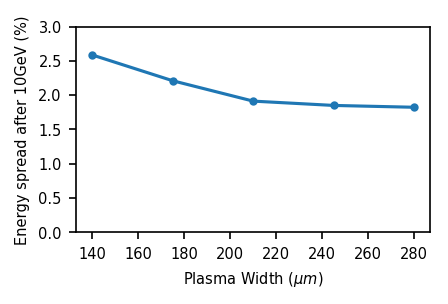

In [9]:
plt.figure(figsize=(3,2), dpi=150)
plt.plot(plasma_width, spread, marker='o', markersize=3)
plt.ylabel('Energy spread after 10GeV (%)')
plt.xlabel(r'Plasma Width ($\mu m$)')
plt.ylim(0, 3)
plt.tight_layout()
plt.show()

In [10]:
# Get the wake size
lengthA = np.zeros(len(plasma_width))
widthA = np.zeros(len(plasma_width))
def find_length(rhoX, x, Nx):
    eps = 1e6
    for i in range(Nx-1, -1, -1):
        if rhoX[i] >= eps and rhoX[i-1] < eps:
            start = x[i-1]
        if rhoX[i] <= eps and rhoX[i-1] > eps:
            end = x[i]
            return start, end
        
def find_width(rhoY, y, Ny):
    eps = 1e6
    start = None
    for i in range(int(Ny/4), int(3*Ny/4)):
        if rhoY[i] >= eps and rhoY[i+1] < eps:
            start = y[i+1]
        if rhoY[i] <= eps and rhoY[i+1] > eps:
            end = y[i]
            if start is None:
                return None, None
            else:
                return start, end
    return None, None

def get_length_width(i):
    path = pathPre + '%0dum/' % (plasma_width[i])
    density = np.load(path + 'DensitySlice.npy').item()
    x = density['xfield']*1e6
    y = density['yfield']*1e6
    Nx = len(x)
    Ny = len(y)
    rhoXY = -density['rhoP'][19]/e/1e6
    rhoX = rhoXY[:, int(Ny/2)]


    length = find_length(rhoX, x, Nx)
    print('Start: %0.2f, End: %0.2f, Length:%0.2f' % (length[0], length[1], length[0]-length[1]))
    lengthA[i] = length[0]-length[1]

    beg = 0
    end = 350
    widthArr = np.zeros(end-beg, dtype='double')
    for j in range(beg, end):
        rhoYj = rhoXY[j, :]
        width = find_width(rhoYj, y, Ny)
        if width[0] is not None:
            widthArr[j-beg] = width[1]-width[0]
        else:
            widthArr[j-beg] = 0
    rhoY = rhoXY[np.argmax(widthArr)+beg, :]
    
    width = find_width(rhoY, y, Ny)
    print('Bottom: %0.2f, Top: %0.2f, Width:%0.2f' % (width[0], width[1], width[1]-width[0]))
    widthA[i] = width[1]-width[0]

    plt.figure(figsize=(7,2.5), dpi=150)
    gs = gridspec.GridSpec(1, 2)
    plt.subplot(gs[0, 0])
    plt.plot(x, rhoX)
    plt.plot([length[0], length[0]], [-0.5e18, 5e18], 'm--')
    plt.plot([length[1], length[1]], [-0.5e18, 5e18], 'm--')
    plt.title('Longitudinal plasma density')
    plt.xlabel(r'$x\,(\mathrm{\mu m})$')
    plt.ylabel(r'$n_e\,(\mathrm{cm^{-3}})$')
    plt.ylim([-0.5e18, 5e18])

    plt.subplot(gs[0, 1])
    plt.plot(y, rhoY)
    plt.title('Transverse plasma density')
    plt.plot([width[0], width[0]], [-0.25e17, 2.5e17], 'm--')
    plt.plot([width[1], width[1]], [-0.25e17, 2.5e17], 'm--')
    plt.xlabel(r'$y\,(\mathrm{\mu m})$')
    plt.ylabel(r'$n_e\,(\mathrm{cm^{-3}})$')
    plt.ylim([-0.25e16, 7.5e16])
    plt.tight_layout()
    plt.show()

Start: 282.00, End: 58.29, Length:223.71
Bottom: 81.02, Top: 218.98, Width:137.97


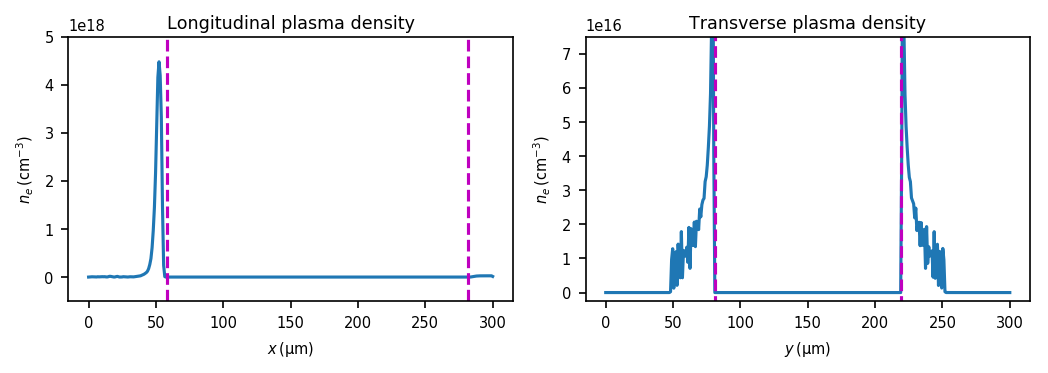

Start: 282.00, End: 66.86, Length:215.14
Bottom: 81.82, Top: 218.18, Width:136.36


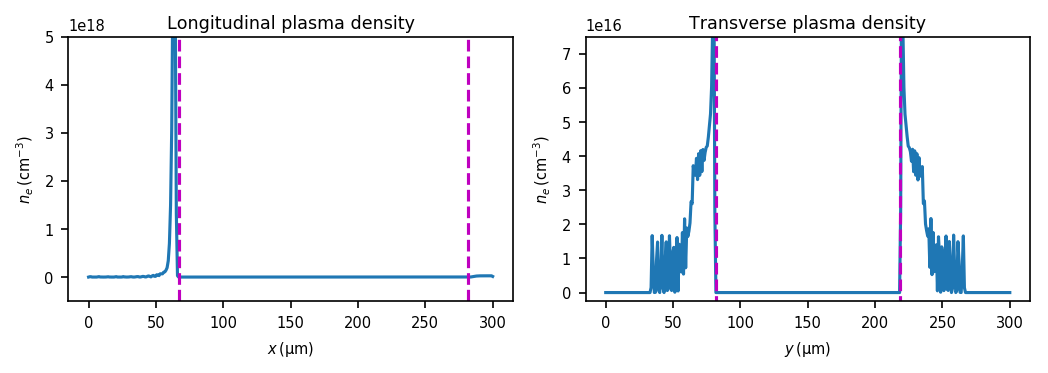

Start: 282.00, End: 69.43, Length:212.57
Bottom: 81.82, Top: 218.18, Width:136.36


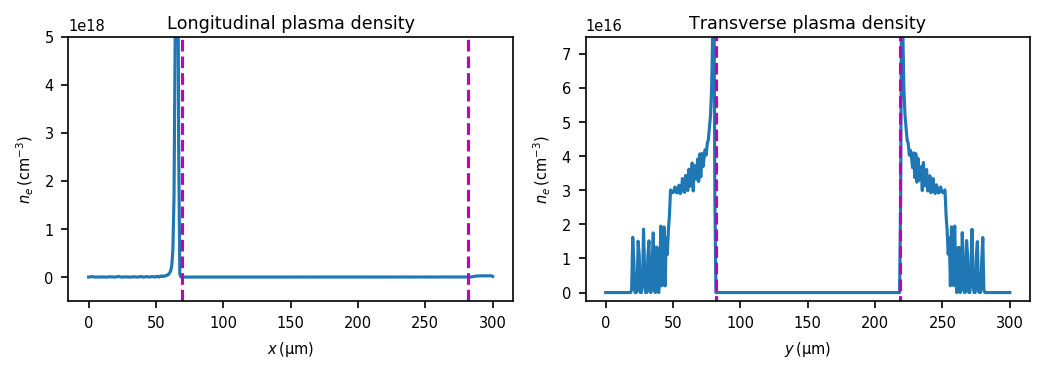

Start: 282.00, End: 68.57, Length:213.43
Bottom: 81.82, Top: 218.18, Width:136.36


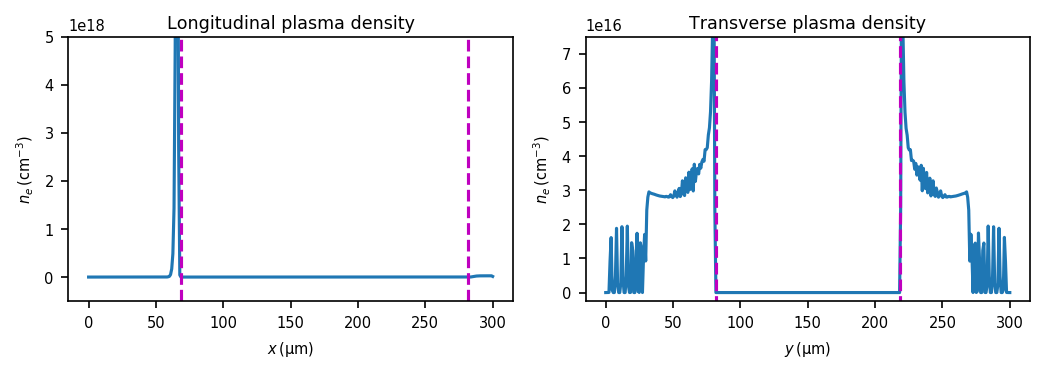

Start: 282.00, End: 68.57, Length:213.43
Bottom: 81.82, Top: 218.18, Width:136.36


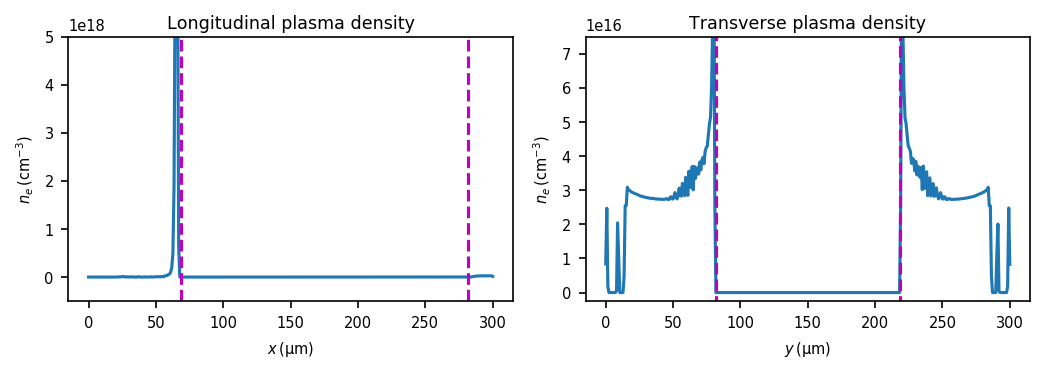

In [11]:
for i in range(len(plasma_width)):
    get_length_width(i)

In [14]:
path = pathPre + '%0dum/' % (plasma_width[1])
density = np.load(path + 'DensitySlice.npy').item()
x = density['xfield']*1e6
y = density['yfield']*1e6
Nx = len(x)
Ny = len(y)
rhoXY = -density['rhoP'][19]/e/1e6
rhoX = rhoXY[:, int(Ny/2)]

length = analyze.find_length(rhoX, x)
print('Start: %0.2f, End: %0.2f, Length:%0.2f' % (length[0], length[1], length[0]-length[1]))
width = analyze.find_wake_width(rhoXY, y)
print('Bottom: %0.2f, Top: %0.2f, Width:%0.2f' % (width[0], width[1], width[1]-width[0]))

Start: 282.00, End: 66.86, Length:215.14
Bottom: 81.82, Top: 218.18, Width:136.36


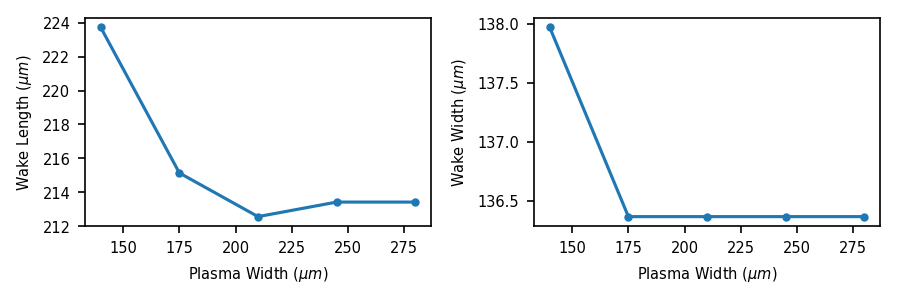

In [13]:
plt.figure(figsize=(6,2), dpi=150)
plt.subplot(121)
plt.plot(plasma_width, lengthA, marker='o', markersize=3)
plt.ylabel('Wake Length ($\mu m$)')
plt.xlabel(r'Plasma Width ($\mu m$)')
#plt.ylim(0, 3)
plt.subplot(122)
plt.plot(plasma_width, widthA, marker='o', markersize=3)
plt.ylabel('Wake Width ($\mu m$)')
plt.xlabel(r'Plasma Width ($\mu m$)')
plt.tight_layout()
plt.show()